#### Importing the libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# --- Configuration ---
# NOTE: This script assumes the input file is the 500-row dataset generated previously.
ORIGINAL_FILENAME = 'Bangladeshi_Student_Database.xlsx'
DROPPED_FILENAME = 'Data_Dropped_Missing.xlsx'
IMPUTED_FILENAME = 'Data_Imputed_Missing.xlsx'
FINAL_COMPARISON_FILENAME = 'Data_Comparison_Joined.xlsx'
NUM_SAMPLES_FOR_PLOT = 50

# --- Main Script ---
print("--- Starting Data Processing and Comparison Workflow ---")

# --- Step 1: Load the Original Dataset ---
try:
    df_original = pd.read_excel(ORIGINAL_FILENAME)
    print(f"\nSuccessfully loaded '{ORIGINAL_FILENAME}'.")
except FileNotFoundError:
    print(f"\nError: The file '{ORIGINAL_FILENAME}' was not found.")
    print("Please make sure it's in the same folder as this script.")
    exit()

# --- Step 2: Create the 'Dropped Data' File ---
print(f"\n[Strategy A] Creating file with dropped missing values...")
df_dropped = df_original.dropna()
df_dropped.to_excel(DROPPED_FILENAME, index=False)
print(f"-> Successfully saved '{DROPPED_FILENAME}'. It has {len(df_dropped)} rows.")

# --- Step 3: Create the 'Imputed Data' File ---
print(f"\n[Strategy B] Creating file with imputed missing values...")
df_imputed = df_original.copy()
# Calculate mean for Age and median for Exam Marks from the original data
age_mean = df_imputed['Age'].mean()
marks_median = df_imputed['Exam Marks'].median()
# Fill missing values
df_imputed['Age'] = df_imputed['Age'].fillna(age_mean)
df_imputed['Exam Marks'] = df_imputed['Exam Marks'].fillna(marks_median)

# ADDED: Round the imputed ages to the nearest whole number and convert to integer
df_imputed['Age'] = df_imputed['Age'].round(0).astype(int)

df_imputed.to_excel(IMPUTED_FILENAME, index=False)
print(f"-> Successfully saved '{IMPUTED_FILENAME}'. It has {len(df_imputed)} rows.")

# --- Step 4: Normalize Both Datasets Independently ---
print("\nNormalizing both datasets...")
scaler = MinMaxScaler()

# Normalize the dropped dataset
df_dropped_normalized = df_dropped.copy()
df_dropped_normalized[['Age_Normalized_Dropped', 'Marks_Normalized_Dropped']] = scaler.fit_transform(df_dropped_normalized[['Age', 'Exam Marks']])

# Normalize the imputed dataset
df_imputed_normalized = df_imputed.copy()
df_imputed_normalized[['Age_Normalized_Imputed', 'Marks_Normalized_Imputed']] = scaler.fit_transform(df_imputed_normalized[['Age', 'Exam Marks']])
print("-> Normalization complete for both strategies.")

# --- Step 5: Combine Using a 'Left Merge' ---
print(f"\nMerging the two normalized datasets using 'Name' as the key...")
# Select only the necessary columns for the merge
df_dropped_subset = df_dropped_normalized[['Name', 'Age_Normalized_Dropped', 'Marks_Normalized_Dropped']]
# Start with the full imputed dataset and merge the dropped data into it
df_final_comparison = pd.merge(df_imputed_normalized, df_dropped_subset, on='Name', how='left')
print("-> Merge complete.")

# --- Step 6: Save the Final Comparison File ---
df_final_comparison.to_excel(FINAL_COMPARISON_FILENAME, index=False)
print(f"-> Successfully saved final comparison file: '{FINAL_COMPARISON_FILENAME}'")

# --- Step 7: Generate Filtered Comparison Plots ---
print("\nGenerating comparison plots...")

# REVISED LOGIC: First, create a new DataFrame containing only students who
# exist in BOTH the imputed and dropped datasets by removing rows with any nulls.
print(f"Finding students present in both datasets for a direct comparison...")
df_plot_base = df_final_comparison.dropna(subset=['Age_Normalized_Dropped', 'Marks_Normalized_Dropped'])
print(f"-> Found {len(df_plot_base)} students with complete data across both strategies.")


--- Starting Data Processing and Comparison Workflow ---

Successfully loaded 'Bangladeshi_Student_Database.xlsx'.

[Strategy A] Creating file with dropped missing values...
-> Successfully saved 'Data_Dropped_Missing.xlsx'. It has 298 rows.

[Strategy B] Creating file with imputed missing values...
-> Successfully saved 'Data_Imputed_Missing.xlsx'. It has 500 rows.

Normalizing both datasets...
-> Normalization complete for both strategies.

Merging the two normalized datasets using 'Name' as the key...
-> Merge complete.
-> Successfully saved final comparison file: 'Data_Comparison_Joined.xlsx'

Generating comparison plots...
Finding students present in both datasets for a direct comparison...
-> Found 298 students with complete data across both strategies.


Taking a random sample of up to 50 students for the plots...
-> Sample created with 50 students.

--- Workflow Complete ---
Check your folder for the three generated Excel files.
Displaying comparison plots now.


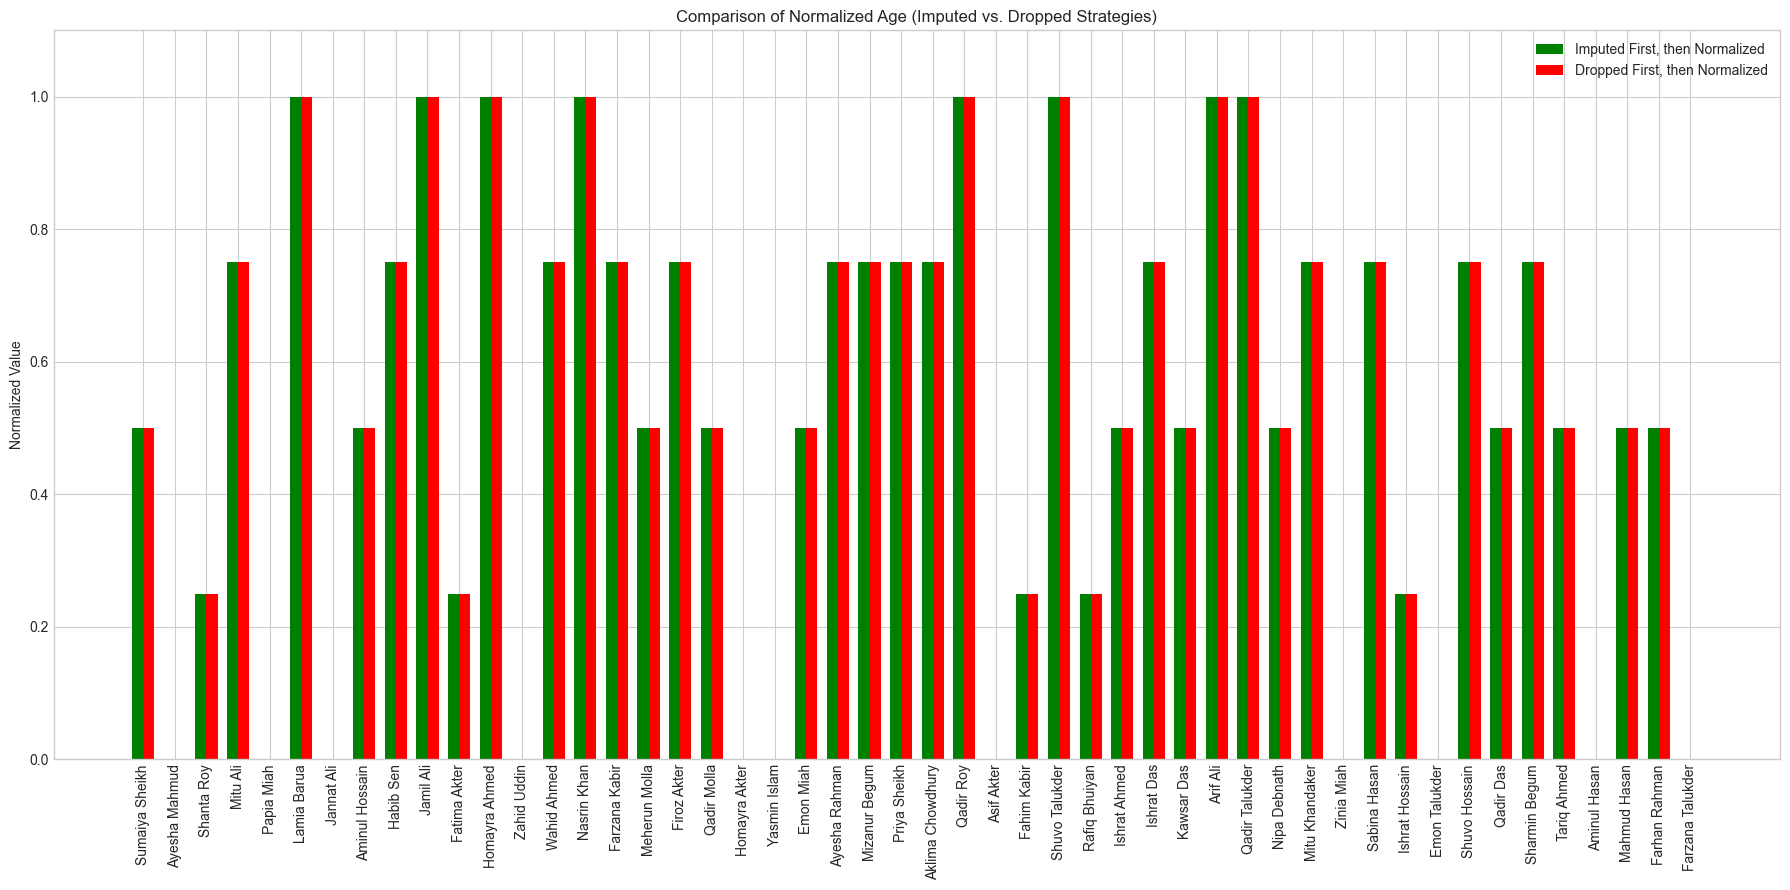

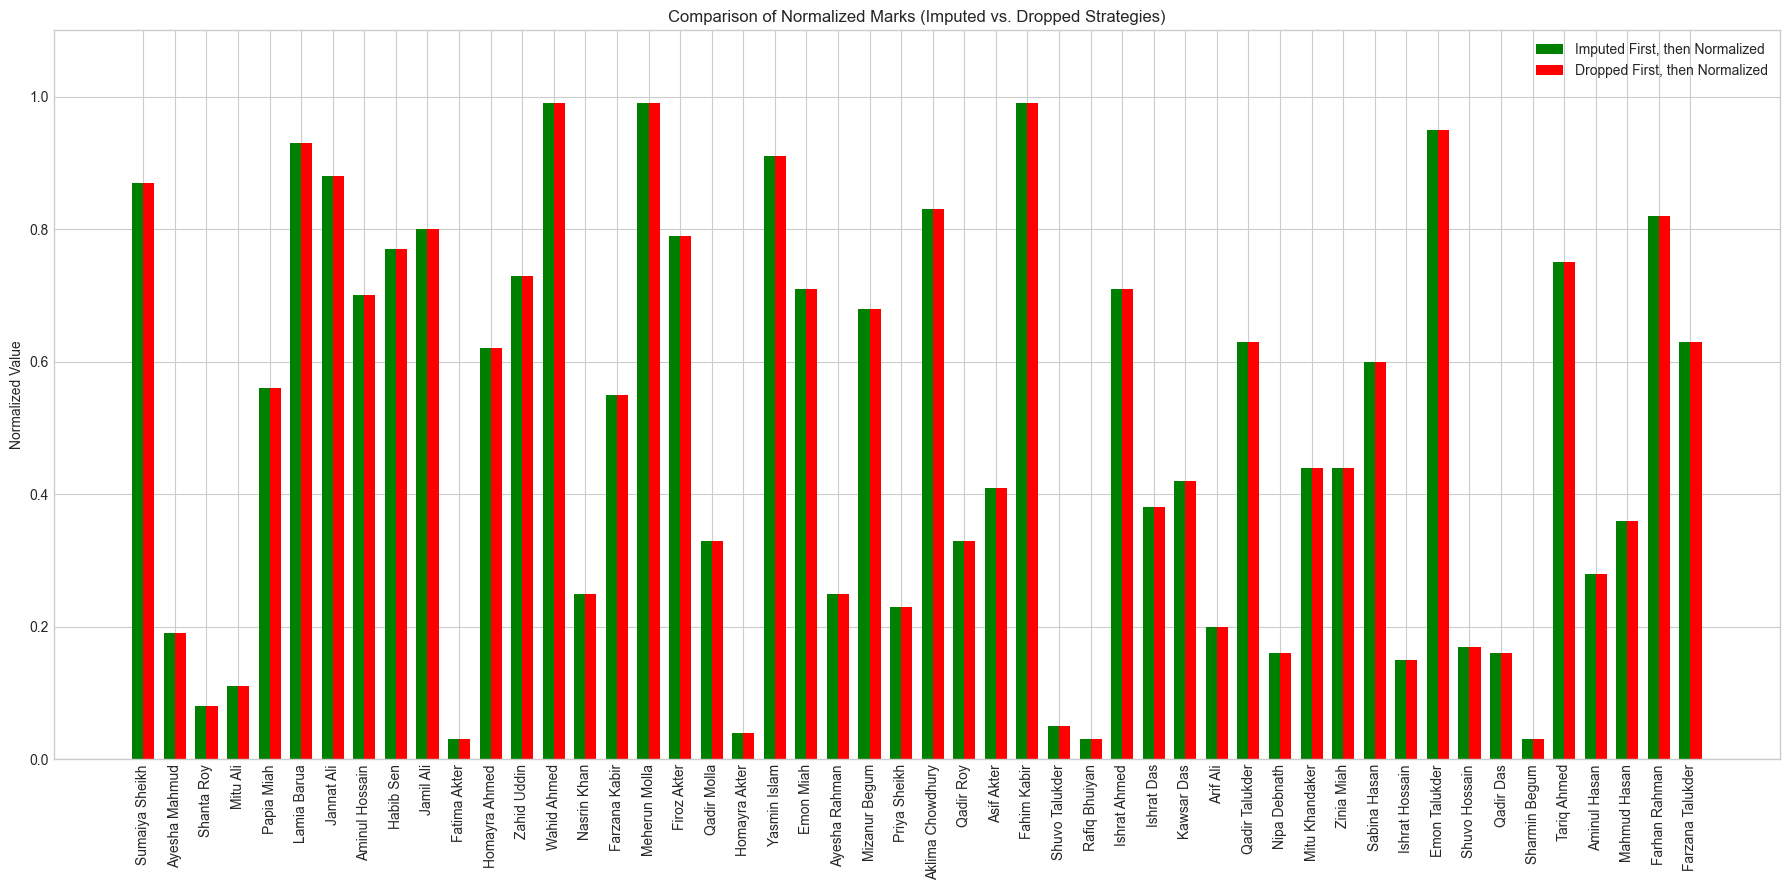

In [4]:
# REVISED LOGIC: Second, from this clean, filtered group, take a random sample.
print(f"Taking a random sample of up to {NUM_SAMPLES_FOR_PLOT} students for the plots...")
if len(df_plot_base) >= NUM_SAMPLES_FOR_PLOT:
    plot_sample = df_plot_base.sample(n=NUM_SAMPLES_FOR_PLOT, random_state=42)
else:
    print(f"Warning: Fewer than {NUM_SAMPLES_FOR_PLOT} complete rows available. Using all {len(df_plot_base)} rows.")
    plot_sample = df_plot_base
print(f"-> Sample created with {len(plot_sample)} students.")


# --- Age Normalization Plot ---
plt.style.use('seaborn-v0_8-whitegrid')
fig1, ax1 = plt.subplots(figsize=(18, 9))
x = np.arange(len(plot_sample['Name']))  # the label locations
width = 0.35  # the width of the bars

rects1 = ax1.bar(x - width/2, plot_sample['Age_Normalized_Imputed'], width, label='Imputed First, then Normalized', color='green')
rects2 = ax1.bar(x + width/2, plot_sample['Age_Normalized_Dropped'], width, label='Dropped First, then Normalized', color='red')

# Add some text for labels, title and axes ticks
ax1.set_ylabel('Normalized Value')
ax1.set_title('Comparison of Normalized Age (Imputed vs. Dropped Strategies)')
ax1.set_xticks(x)
ax1.set_xticklabels(plot_sample['Name'], rotation=90)
ax1.legend()
ax1.set_ylim(0, 1.1) # Set y-axis limit
fig1.tight_layout()

# --- Marks Normalization Plot ---
fig2, ax2 = plt.subplots(figsize=(18, 9))
rects3 = ax2.bar(x - width/2, plot_sample['Marks_Normalized_Imputed'], width, label='Imputed First, then Normalized', color='green')
rects4 = ax2.bar(x + width/2, plot_sample['Marks_Normalized_Dropped'], width, label='Dropped First, then Normalized', color='red')

# Add some text for labels, title and axes ticks
ax2.set_ylabel('Normalized Value')
ax2.set_title('Comparison of Normalized Marks (Imputed vs. Dropped Strategies)')
ax2.set_xticks(x)
ax2.set_xticklabels(plot_sample['Name'], rotation=90)
ax2.legend()
ax2.set_ylim(0, 1.1) # Set y-axis limit
fig2.tight_layout()

print("\n--- Workflow Complete ---")
print("Check your folder for the three generated Excel files.")
print("Displaying comparison plots now.")
plt.show()
